# CSE 541 HW 3
Evan Komp

In [1]:
import numpy as np
from mnist import MNIST
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.linear_model
import scipy.stats

import matplotlib.pyplot as plt

***
## 1

Expected regret of tau greedy

For $n$ total timesteps nature reveals $(C_t)_{t=1}^n\in \mathcal{C}$ contexts. We take an action $A_t \in [k]$ and observe reward $X_t$ based on context and action taken. Define $\mu(C_t, A_t) = \mathbb{E}(X_t) = \int x P(x|A_t,C_t)$. For policies $\phi\in\Phi: \mathcal{C}\rightarrow k$ define $\mu(\phi)=\int\mu(C,\phi(C)d\xi(C))$.

The regret of any algorithm:

$$R_n = n\cdot sup_\phi \mu(\phi) - \mathbb{E}\left[\sum_t^n X_t\right]$$

The tau greedy algorithm:

1. For $m$ rounds, select $A_t$ uniformly at random from $[k]$. Define $\hat{\mu}(\phi) = \frac{k}{m}\sum_{t=1}^m \mathbb{1}\{A_t=\phi(C_t)\}X_t$. $\hat{X}_{ti}=k\mathbb{1}\{A_t=\phi(C_t)\}X_t$
2. For $t=m,...,n$ select $A_t = [\textrm{argmax}_\phi \hat{\mu}(\phi)](C_t)$


To bound the expected regret, we first need to bound regret with high probability. We can do this by showing that our policy value estimator $\hat{\mu}$ is close to the true policy value $\mu$ by some bound. If the estimator is constructed properly, we can use bernstein's innequality to bound this difference. 

First let us prove that our estimator is unbiased:

1. $$\mathbb{E}[\hat{\mu}(\phi)] = \frac{1}{m}\sum^m_{t=1}\mathbb{E}[\hat{X}_{t\phi(C_t)}]= \frac{1}{m}\sum^m_{t=1}\mathbb{E}_{C_t\sim\mathcal{C}}[\mathbb{E}[\hat{X}_{t\phi(C_t)}|C_t]]$$

2. $$\mathbb{E}[\hat{X}_{t\phi(C_t)}|C_t] = \mathbb{E}[k\mathbb{1}\{A_t=\phi(C_t)\}X_t|C_t]$$

Noting that the probability of any arm is $1/k$ since we sampled uniformly, and the indicator is only on for one of those actions:

$$=\sum_{A_t'\in [k]}\frac{1}{k}\mathbb{E}[k\mathbb{1}\{A_t=\phi(C_t)\}X_t|C_t, A_t = A_t'] = \sum_{A_t'\in [k]}\mathbb{1}\{A_t'=\phi(C_t)\}\mu(C_t,A_t') = \mu(C_t,A_t)$$

Plugging this back into (1):

$$\frac{1}{m}\sum^m_{t=1}\mathbb{E}_{C_t\sim\mathcal{C}}[\mu(C_t,A_t)] = \mu(\phi)$$

Unbiased!

And the variance:

$$\mathbb{E}[(\hat{\mu}(\phi)-\mathbb{E}[\hat{\mu}(\phi)])^2] = \mathbb{E}[(\hat{\mu}(\phi)-\mu(\phi))^2]$$

Noting that $X_t, \hat{X_{ti}}\in [0,1]$

$$= \frac{1}{m^2}\sum_{t=1}^m\mathbb{E}_{C_t\sim\mathcal{C}}\left[\mathbb{E}\left[(\hat{X}_{t\phi(C_t)}-X_t)^2|C_t\right]\right]$$

$$\le \frac{1}{m^2}\sum_{t=1}^m\mathbb{E}_{C_t\sim\mathcal{C}}\left[\mathbb{E}\left[\hat{X}_{t\phi(C_t)}^2|C_t\right]\right] = \frac{1}{m^2}\sum_{t=1}^m\mathbb{E}_{C_t\sim\mathcal{C}}\left[\mathbb{E}\left[(k\mathbb{1}\{A_t=\phi(C_t)\}X_t)^2|C_t\right]\right]$$

Again, since $X_t\le 1$:

$$\le \frac{1}{m^2}\sum_{t=1}^m\mathbb{E}_{C_t\sim\mathcal{C}}\left[]\right]$$

***
## 2

I note that for all of these algorithms, we ultimately rely on a linear predictor. Because of this, if our linear predictor is insufficient for accurate prediction, we will always have linear regret, even if a very small slope. Congruently, PCAing down to a point of significant information loss will also mean the model is incapable of making accurate predictions. For this reason, as a first step, I use the dataset in a standard supervised setting sith a linear SGD classifier, and assess different values of $d$ for PCA

In [80]:
def prepare_data(d):
    mndata = MNIST('../../python-mnist/data')
    # mndata.select_emnist('balanced')
    images, labels = mndata.load_training()
    images = np.array(images)
    labels = np.array(labels)
    
    num_each = 5000
    C = []
    y = []
    for digit in np.unique(labels):
        mask = np.argwhere(labels == digit)
        C_select = images[mask.reshape(-1)]
        y_select = labels[mask]
        ind = np.random.choice(len(mask), size=num_each, replace=False)
        C.append(C_select[ind])
        y.append(y_select[ind])
    C = np.concatenate(C)
    y = np.concatenate(y)

    # shuffle the results
    ind = np.random.choice(len(y), size=len(y), replace=False)
    C = C[ind]
    y = y[ind]
    
    # PCA to d and scale
    pca = sklearn.decomposition.PCA(d)
    C = pca.fit_transform(C)
    # scaler = sklearn.preprocessing.MinMaxScaler()
    # C = scaler.fit_transform(C)
    scaler = sklearn.preprocessing.Normalizer()
    C = scaler.fit_transform(C)
    # C = C / np.linalg.norm(C, axis=1).reshape(-1,1)
    
    return C, y

In [82]:
for d in range(10, 200, 10):
    C, y = prepare_data(d)
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(C, y, test_size=0.2)
    
    model = sklearn.linear_model.SGDClassifier()
    model.fit(X_train, y_train.reshape(-1))
    score = model.score(X_test, y_test.reshape(-1))
    print(d, score)

10 0.7313
20 0.857
30 0.8674
40 0.8831
50 0.893
60 0.892
70 0.8949
80 0.8964
90 0.8982
100 0.896
110 0.9037
120 0.9023
130 0.9043
140 0.9071
150 0.8978
160 0.8989
170 0.9045
180 0.8976
190 0.9059


It seems that there is minimal test accuracy increase for $d > 50$, so I will use this number for the linear bandit algorithms. However, since the test accuracy is not 100% it is not possible for the algorithm reach a point where it incurrs no regret, because a linear model with this dataset is not capable of predicting accurately 100% of the time.

In [83]:
C, y = prepare_data(50)
np.save('C.npy', C)
np.save('y.npy', y)


> Choice of $\tau$?

In problem 1 we proved a high probability regret bound for ETC/$\tau$-greedy. In that analysis we found that the choice of $\tau = (kT^2\log{(2 |\Phi|/\delta)})^{1/3}$ where $|\Phi|$ is the cardinality of our policy space. Given that we are enforcing our policy to be a linear estimator of reward acting on $\phi(c_t, a_t)$ with size $10d$, and each of those $10d$ linear parameters could cause the policy to estimate reward as $(0,1)$, we have $|\Phi| = 20d$. If we chose $d$ for PCA to be 50 as discussed previously, this means $\tau = 6422$ creates an estimator within the confidence bound with $95\%$ certainty.

The regret results of the 5 algorithms using the above dataset and $\tau$ are shown below. Three trajectories were taken for each, with standard deviation as error bars. The python classes and scripts used to create this data are shown at the bottom of this document.

## Model classes

In [46]:
class Agent:
    
    def __init__(self, C, y, T, n=n, gamma=1.0, log_rate=10):
        self.C = C
        self.y = y
        self.T = T
        self.n = n
        self.gamma = gamma
        self.log_rate = log_rate
        self.R_log = []
        self.R = 0.0
        self.t = 0
        self.d = C.shape[1]
        self.phi_d = int(self.d*n)
        
        self.V = np.eye(self.phi_d) * gamma
        self.V_inv = np.linalg.inv(self.V)
        self.log_det_V0 = self.phi_d*np.log(self.gamma)
        self.log_det_V = self.phi_d*np.log(self.gamma)
        self.S = np.zeros((self.phi_d,1))
        
        self.L = max(np.linalg.norm(C, axis=1))
        
        self.startup()
        return
    
    @property
    def theta(self):
        return self.V_inv @ self.S
    
    def startup(self):
        raise NotImplemented()
        
    def phi(self, ind, a):
        """Featurize the action played and the context given.
        
        Parameters
        ----------
        ind : index of context raised
        a : index of action played
        """
        c = self.C[ind]
        out = np.zeros((self.n, c.size))
        out[a] = c
        assert out.size == self.phi_d
        return out.flatten()
    
    def r(self, ind, a):
        """Reward
        
        Parameters
        ----------
        ind : index of context raised
        a : index of action played
        """
        return int(self.y[ind] == a)
    
    def pull(self, ind, a):
        """Commit an agent action. Updates regret.
        
        The problem statement was fixed to have optimal policy always give reward of 1.
        So for a play is just 1 - reward
        
        Parameters
        ----------
        ind : index of context raised
        a : index of action played
        """
        r = self.r(ind, a)
        self.R += 1.0 - r
        if r != 1:
            # print('!!!regret incurred!!!')
            pass
            
        self.update(ind, a, r)
        # print(f'Pulled arm {a} for context {ind} and recieved reward {r}.')
        if self.t % self.log_rate == 0:
            self.R_log.append((self.t, self.R))
        self.t += 1
        return r
    
    def run(self):
        """Run the algorithm until T."""
        regret = []
        while self.t < self.T:
            ind_t = self.t
            at = self.pick(ind_t)
            r = self.pull(ind_t, at)
            regret.append(1-r)
        return regret
    
    def pick(self, ind):
        """Pick arm based on context vector
        
        parameters
        ind - index of the context that was raised
        """
        raise NotImplemented()
        
    def update(self, ind, a, r):
        phis = self.phi(ind,a).reshape((-1,1))
        self.S += r * phis
        self.V += phis @ (phis.T)
        self.log_det_V = self.log_det_V + np.log(1 + phis.T @ self.V_inv @ phis)
        self.V_inv = self.V_inv - (self.V_inv @ phis @ phis.T @ self.V_inv)/(1 + phis.T @ self.V_inv @ phis)
        return
            

## ETC

In [47]:
class ETC(Agent):
    
    def __init__(self, C, y, T, tau, n=n, log_rate=10):
        self.tau = tau
        super().__init__(C, y, T, n=n, log_rate=log_rate)
        return
    
    def startup(self):
        
        for i in range(self.tau):
            
            ind_t = np.random.choice(len(self.y))
            at = np.random.choice(self.n)
            r = self.pull(ind_t, at)
        self.theta_lock = np.array(self.theta)
        return
            
    def pick(self, ind):
        phis = [self.phi(ind, a) for a in range(self.n)]
        r_hats = [self.theta_lock.reshape(1,-1) @ phi.reshape(-1,1) for phi in phis]
        return np.argmax(r_hats)

In [48]:
etc = ETC(C,y, 6000, 5000)

KeyboardInterrupt: 

In [ ]:
_ = etc.run()

In [ ]:
plt.plot(*np.array(etc.R_log).T)

In [ ]:
class ETC_bias(Agent):
    
    def __init__(self, C, y, T, tau, n=n, log_rate=10):
        self.tau = tau
        super().__init__(C, y, T, n=n, log_rate=log_rate)
        return
    
    def startup(self):
        Cs = []
        ys = []
        for i in range(self.tau):
            ind_t = np.random.choice(len(self.y))
            at = np.random.choice(self.n)
            r = self.pull(ind_t, at)
            if r == 1:
                Cs.append(self.C[ind_t])
                ys.append(self.y[ind_t])
        Cs = np.array(Cs)
        ys = np.array(ys).reshape(-1,1)
        
        model = sklearn.linear_model.SGDClassifier()
        model.fit(Cs, ys)
        self.model = model
        return
            
    def pick(self, ind):
        at = self.model.predict(self.C[ind].reshape(1,-1))
        return int(at)

In [ ]:
etc_bias = ETC_bias(C,y, 20000, 1000)

In [ ]:
etc_bias.run()

In [ ]:
plt.plot(*np.array(etc_bias.R_log).T)

In [ ]:
class FTL(ETC):
    
    def pick(self, ind):
        phis = [self.phi(ind, a) for a in range(self.n)]
        r_hats = np.array([self.theta.reshape(1,-1) @ phi.reshape(-1,1) for phi in phis])
        return randargmax(r_hats)
    

In [ ]:
ftl = FTL(C,y, 20000, 1000)

In [ ]:
ftl.run()

In [ ]:
np.linalg.norm(ftl.theta)

In [ ]:
plt.plot(*np.array(ftl.R_log).T)

## UCB

In [ ]:
class UCB(Agent):
    
    def __init__(self, C, y, T, beta_type='const', max_bound=False, n=n, gamma=1.0, log_rate=10):
        self.max_bound = max_bound
        self.beta_type = beta_type
        self.beta_log = []
        self.elip_log = []
        super().__init__(C, y, T, n=n, log_rate=log_rate, gamma=gamma)
        return
    
    
    def startup(self):
        self.del_ = 1/self.T
        return
    
    @property
    def beta(self):
        if self.beta_type == 'det':
            return (
                np.sqrt(self.gamma) + np.sqrt(
                    2*np.log(1/self.del_) + self.log_det_V - self.log_det_V0)
                )
        elif self.beta_type == 'const':
            return (
                np.sqrt(self.gamma) + np.sqrt(
                    2*np.log(1/self.del_)
                )
            )
        elif self.beta_type == 'L':
            d = self.phi_d
            return (
                np.sqrt(self.gamma) + np.sqrt(
                    2*np.log(1/self.del_) + d*np.log((d*self.gamma + self.T*self.L**2)/(d*self.L)))
            )
    
    def pick(self, ind):
        print(f'Context {ind} revealed with true label {self.y[ind]}')
        beta = self.beta
        self.beta_log.append(beta)
        theta = self.theta
        phis = np.array([self.phi(ind, a) for a in range(self.n)])
        r_hats = phis @ theta
        elip = []
        for phi in phis:
            elip.append(phi.reshape(1,-1) @ self.V_inv @ phi.reshape(-1,1))
        elip = np.array(elip).reshape(-1,1)
        self.elip_log.append(elip)
        bound = beta * elip
        if self.max_bound:
            bound = bound/max(bound)
            
        print('det V: ', np.linalg.det(self.V))
        print('Beta: ', beta)
        print('Predicted reward:confidence')
        print(np.concatenate([r_hats, bound], axis=1))
        a = randargmax(r_hats + bound)
        print(f'Chose arm {a}')
        return a

In [ ]:
ucb = UCB(C,y, 50000, gamma = 2, beta_type='det', max_bound=False)

In [ ]:
regret = ucb.run()

In [ ]:
plt.plot(*np.array(ucb.R_log).T)

In [ ]:
plt.plot(ucb.beta_log)

In [ ]:
plt.plot(np.array(ucb.elip_log)[:,1])

In [ ]:
beta = np.vstack(ucb.beta_log).reshape(-1)
elip = np.array(ucb.elip_log)[:,2].reshape(-1)

In [ ]:
bound = beta * elip

In [ ]:
plt.plot(bound)

## Thompson

In [31]:
class Thompson(Agent):
    
    def startup(self):
        return
    
    def pick(self, ind):
        theta = self.theta
        V_inv = self.V_inv
        theta_sample = scipy.stats.multivariate_normal(mean=theta.reshape(-1), cov=V_inv).rvs().reshape(-1,1)
        phis = np.array([self.phi(ind, a) for a in range(self.n)])
        r_hats = phis @ theta
        a = np.argmax(r_hats)
        return a

In [32]:
thomp = Thompson(C, y, 10000)

In [33]:
thomp.run()

!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret incurred!!!
!!!regret 

[0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,


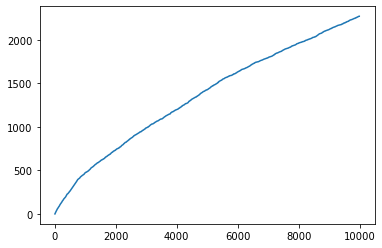

In [34]:
plt.plot(*np.array(thomp.R_log).T)

In [38]:
Thompson.__name__

'Thompson'